In [5]:
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Define a function to extract audio features
def extract_features(audio_path, sr=22050, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=sr)
    # Extract features: MFCC, chroma, mel-spectrogram, spectral contrast, tonal centroid
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).mean(axis=1)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
    mel = librosa.feature.melspectrogram(y=y, sr=sr).mean(axis=1)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).mean(axis=1)

    features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
    return features

# Define a function to load and extract features from the dataset
def load_dataset(data_dir):
    features_list = []
    emotions = []
    
    # List all files in the dataset directory and print them for debugging
    for root, dirs, files in os.walk(data_dir):
        print(f"Checking directory: {root}")
        for file in files:
            if file.endswith('.wav'):
                print(f"Processing file: {file} in {root}")
                try:
                    emotion = file.split('-')[2]  # Modify this based on your filename structure
                    audio_path = os.path.join(root, file)
                    features = extract_features(audio_path)
                    features_list.append(features)
                    emotions.append(emotion)
                except IndexError:
                    print(f"Failed to extract emotion from file: {file}")

    return np.array(features_list), np.array(emotions)

# Load the dataset and extract features
data_dir = r'C:\Users\areeb\Desktop\ml\speech-emotion-recognition-ravdess-data'  # UPDATE WITH DATASET PATH
X, y = load_dataset(data_dir)

# Debug: Check the size of the dataset
print(f"Number of samples: {X.shape[0]}, Number of labels: {y.shape[0]}")

# Encode the emotion labels if dataset is loaded properly
if len(y) > 0:
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Calculate class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Debug: Print class weights
    print(f"Class weights: {class_weights_dict}")
else:
    print("No labels found. Check dataset loading.")


Checking directory: C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data
Checking directory: C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data
Checking directory: C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_01
Processing file: 03-01-01-01-01-01-01.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_01
Processing file: 03-01-01-01-01-02-01.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_01
Processing file: 03-01-01-01-02-01-01.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_01
Processing file: 03-01-01-01-02-02-01.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data

c:\Users\kalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(


Processing file: 03-01-02-02-01-01-13.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_13
Processing file: 03-01-02-02-01-02-13.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_13
Processing file: 03-01-02-02-02-01-13.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_13
Processing file: 03-01-02-02-02-02-13.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_13
Processing file: 03-01-03-01-01-01-13.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-data\Actor_13
Processing file: 03-01-03-01-01-02-13.wav in C:\Users\kalan\OneDrive\Desktop\ml\speech-emotion-recognition-ravdess-data\speech-emotion-recognition-ravdess-

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report

# Define the model architecture
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Create the model
input_shape = X_train_scaled.shape[1]  # Number of features
num_classes = len(np.unique(y_encoded))  # Number of unique emotions
model = create_model(input_shape, num_classes)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_scaled, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test_scaled, y_test), 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded y_test back to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Calculate F1 Score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Optionally, print a classification report for detailed metrics
print(classification_report(y_test_classes, y_pred_classes, target_names=encoder.classes_))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1649 - loss: 2.1252 - val_accuracy: 0.2951 - val_loss: 1.7667
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2869 - loss: 1.8422 - val_accuracy: 0.3993 - val_loss: 1.6421
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3508 - loss: 1.7286 - val_accuracy: 0.4167 - val_loss: 1.5772
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4066 - loss: 1.5919 - val_accuracy: 0.4271 - val_loss: 1.5170
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4594 - loss: 1.4600 - val_accuracy: 0.4583 - val_loss: 1.4515
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4821 - loss: 1.4309 - val_accuracy: 0.4653 - val_loss: 1.4314
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4809 - loss: 1.3910 - val_accuracy: 0.4896 - val_loss: 1.3945
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5307 - loss: 1.2788 - val_accuracy: 0.4931 - val_loss:

c:\Users\kalan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │        85,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,344 (993.53 KB)

 Trainable params: 252,552 (986.53 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1746 - loss: 10.4321 - val_accuracy: 0.3333 - val_loss: 8.9752 - learning_rate: 0.0010
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2906 - loss: 9.3329 - val_accuracy: 0.3681 - val_loss: 8.3912 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3682 - loss: 8.5195 - val_accuracy: 0.4340 - val_loss: 7.7708 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4204 - loss: 7.9189 - val_accuracy: 0.4444 - val_loss: 7.2871 - learning_rate: 0.0010
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4381 - loss: 7.3367 - val_accuracy: 0.4653 - val_loss: 6.7576 - learning_rate: 0.0010
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4286 - loss: 6.9568 - val_accuracy: 0.4688 - val_loss: 6.3720 - learning_rate: 0.0010
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4995 - loss: 6.3641 - val_ac

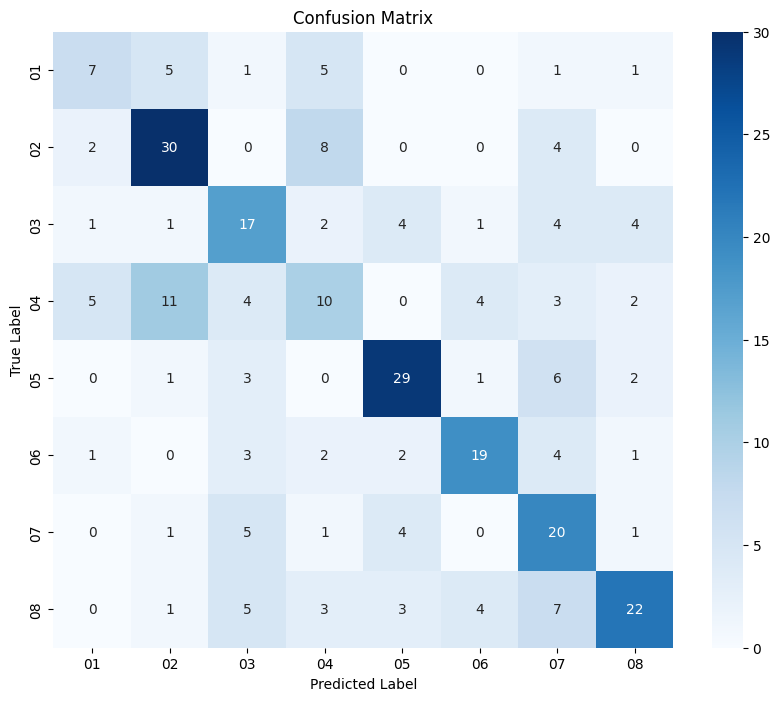

              precision    recall  f1-score   support

          01       0.44      0.35      0.39        20
          02       0.60      0.68      0.64        44
          03       0.45      0.50      0.47        34
          04       0.32      0.26      0.29        39
          05       0.69      0.69      0.69        42
          06       0.66      0.59      0.62        32
          07       0.41      0.62      0.49        32
          08       0.67      0.49      0.56        45

    accuracy                           0.53       288
   macro avg       0.53      0.52      0.52       288
weighted avg       0.54      0.53      0.53       288



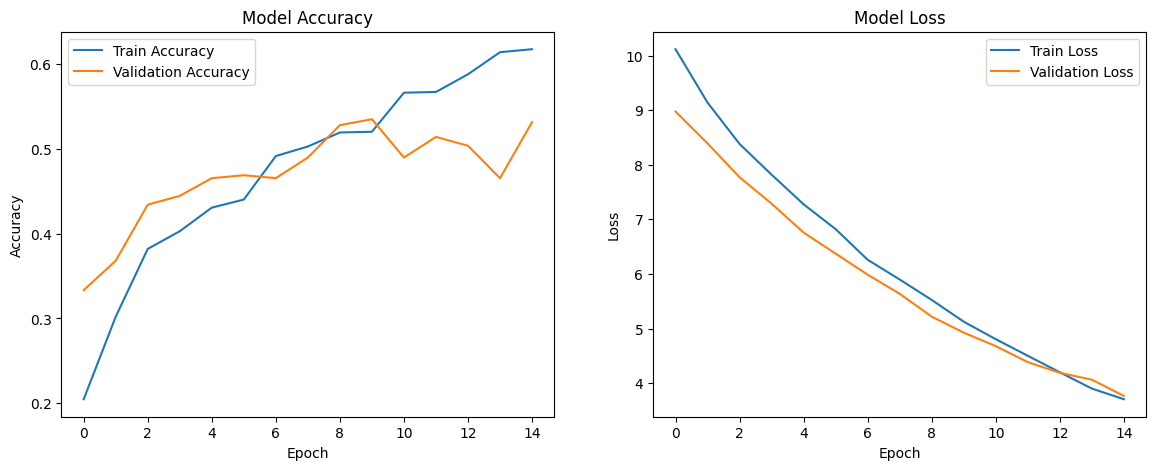

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create an MLP model with increased complexity
def create_mlp_model(input_shape):
    model = Sequential()
    
    # Input layer with increased neurons
    model.add(Dense(512, input_shape=(input_shape,), activation='relu', kernel_regularizer=l2(0.01)))  # Increased neurons
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Adjusted dropout rate
    
    # Hidden layer 1 with increased neurons
    model.add(Dense(256, activation='tanh', kernel_regularizer=l2(0.01)))  # Increased neurons
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Adjusted dropout rate
    
    # Hidden layer 2
    model.add(Dense(128, activation='tanh', kernel_regularizer=l2(0.01)))  # Increased neurons
    model.add(BatchNormalization())
    model.add(Dropout(0.4))  # Adjusted dropout rate
    
    # Output layer for 8 emotion categories
    model.add(Dense(8, activation='sigmoid'))
    
    # Compile the model using Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train the model
mlp_model = create_mlp_model(X_train_scaled.shape[1])
mlp_model.summary()

# Define callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  # Monitor validation accuracy
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # Adjust learning rate

# Train the model with increased epochs
history = mlp_model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test),
                        epochs=100,  # Increased epochs for more training
                        batch_size=32,
                        callbacks=[early_stopping, reduce_lr])

# Evaluate the model on training and test data
train_loss, train_accuracy = mlp_model.evaluate(X_train_scaled, y_train)
test_loss, test_accuracy = mlp_model.evaluate(X_test_scaled, y_test)

# Print the training and testing accuracy
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

# Make predictions
y_pred_probs = mlp_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

# Optionally, plot the training history to visualize performance
# Plot accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Create a KNN model
knn_model = KNeighborsClassifier()

# Set the hyperparameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 10],              # Different values for number of neighbors
    'weights': ['uniform', 'distance'],        # Weighting schemes
    'metric': ['euclidean', 'manhattan']      # Distance metrics
}

# Perform GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, np.argmax(y_train, axis=1))

# Get the best model
best_knn_model = grid_search.best_estimator_

# Predict on test set
y_pred_knn = best_knn_model.predict(X_test_scaled)

# Print accuracy and classification report
print("Best KNN Accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_pred_knn))
print(classification_report(np.argmax(y_test, axis=1), y_pred_knn, target_names=encoder.classes_))

Best KNN Accuracy: 0.5868055555555556
              precision    recall  f1-score   support

          01       0.47      0.75      0.58        20
          02       0.73      0.68      0.71        44
          03       0.47      0.44      0.45        34
          04       0.47      0.46      0.47        39
          05       0.76      0.62      0.68        42
          06       0.50      0.44      0.47        32
          07       0.56      0.69      0.62        32
          08       0.66      0.64      0.65        45

    accuracy                           0.59       288
   macro avg       0.58      0.59      0.58       288
weighted avg       0.60      0.59      0.59       288



In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the SVM model
svm_model = SVC(probability=True)

# Set the hyperparameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  # Test different kernels
    'C': [0.1, 1, 10, 100],                # Regularization parameter
    'gamma': ['scale', 'auto']             # Kernel coefficient
}

# Perform GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, np.argmax(y_train, axis=1))

# Get the best model
best_svm_model = grid_search.best_estimator_

# Predict on test set
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Print accuracy and classification report
print("Best SVM Accuracy:", accuracy_score(np.argmax(y_test, axis=1), y_pred_svm))
print(classification_report(np.argmax(y_test, axis=1), y_pred_svm, target_names=encoder.classes_))

Best SVM Accuracy: 0.5729166666666666
              precision    recall  f1-score   support

          01       0.45      0.50      0.48        20
          02       0.59      0.66      0.62        44
          03       0.47      0.53      0.50        34
          04       0.50      0.46      0.48        39
          05       0.78      0.67      0.72        42
          06       0.69      0.62      0.66        32
          07       0.47      0.53      0.50        32
          08       0.60      0.56      0.57        45

    accuracy                           0.57       288
   macro avg       0.57      0.57      0.57       288
weighted avg       0.58      0.57      0.58       288



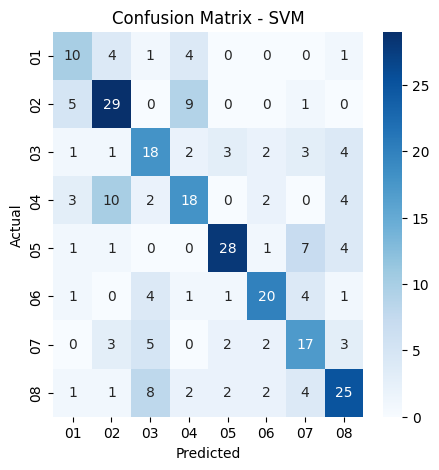

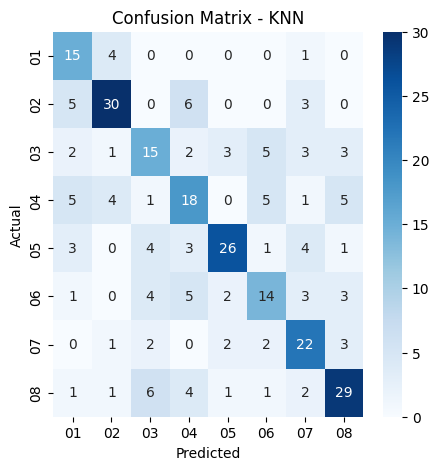

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix with specified labels and model name
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# List of emotion labels
emotion_labels = encoder.classes_  # Ensure this contains the desired labels

# Plot confusion matrix for SVM with model name
plot_confusion_matrix(np.argmax(y_test, axis=1), y_pred_svm, emotion_labels, 'SVM')

# Plot confusion matrix for KNN with model name
plot_confusion_matrix(np.argmax(y_test, axis=1), y_pred_knn, emotion_labels, 'KNN')


In [16]:
from sklearn.model_selection import cross_val_score

# Apply cross-validation on SVM
svm_scores = cross_val_score(svm_model, X_train_scaled, np.argmax(y_train, axis=1), cv=5)
print(f"SVM Cross-Validation Accuracy: {svm_scores.mean()}")

# Apply cross-validation on KNN
knn_scores = cross_val_score(knn_model, X_train_scaled, np.argmax(y_train, axis=1), cv=5)
print(f"KNN Cross-Validation Accuracy: {knn_scores.mean()}")




SVM Cross-Validation Accuracy: 0.44267268962921136
KNN Cross-Validation Accuracy: 0.4383926218708828
